## load the data

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split

In [16]:
pd.set_option('display.max_columns', 30)

In [17]:
data_path = '../data/processed.cleveland.data'

column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
              'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

CATEGORICAL_COLS = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']
NUMERIC_COLS = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

df = pd.read_csv(data_path, header=None, na_values='?', names=column_names)

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


## Exploratory Data Analysis

<Axes: >

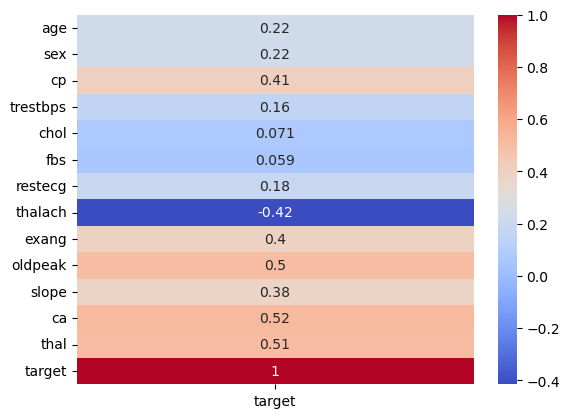

In [19]:
sns.heatmap(df.corr()[['target']], annot=True, cmap='coolwarm')

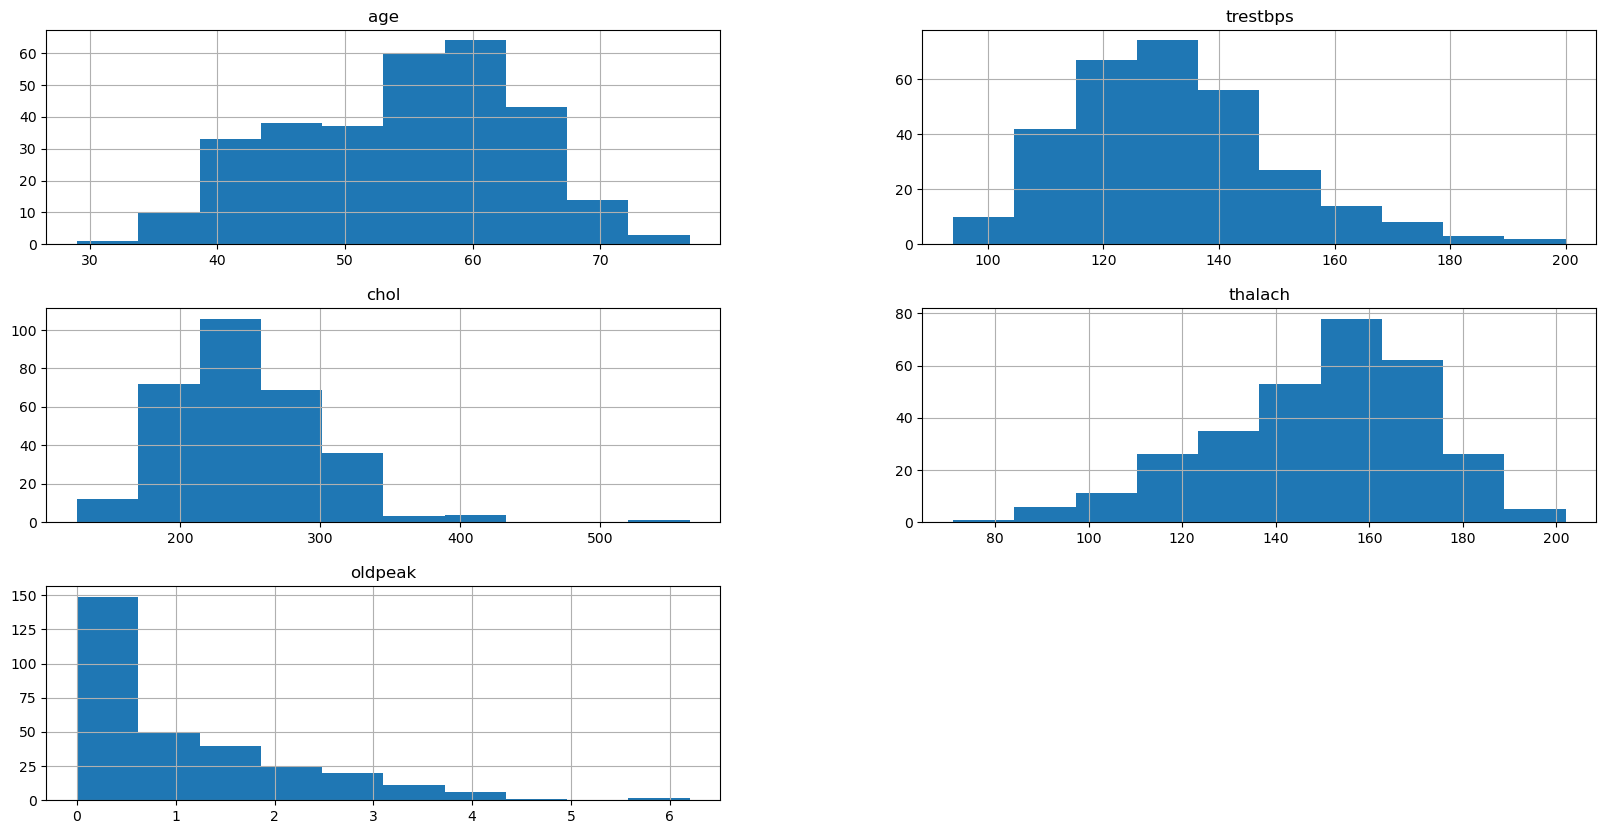

In [20]:
# plot histogram distribution for numeric columns
df[NUMERIC_COLS].hist(figsize=(20,10));

the `oldpeak` is not normally distributed, it is right skewed

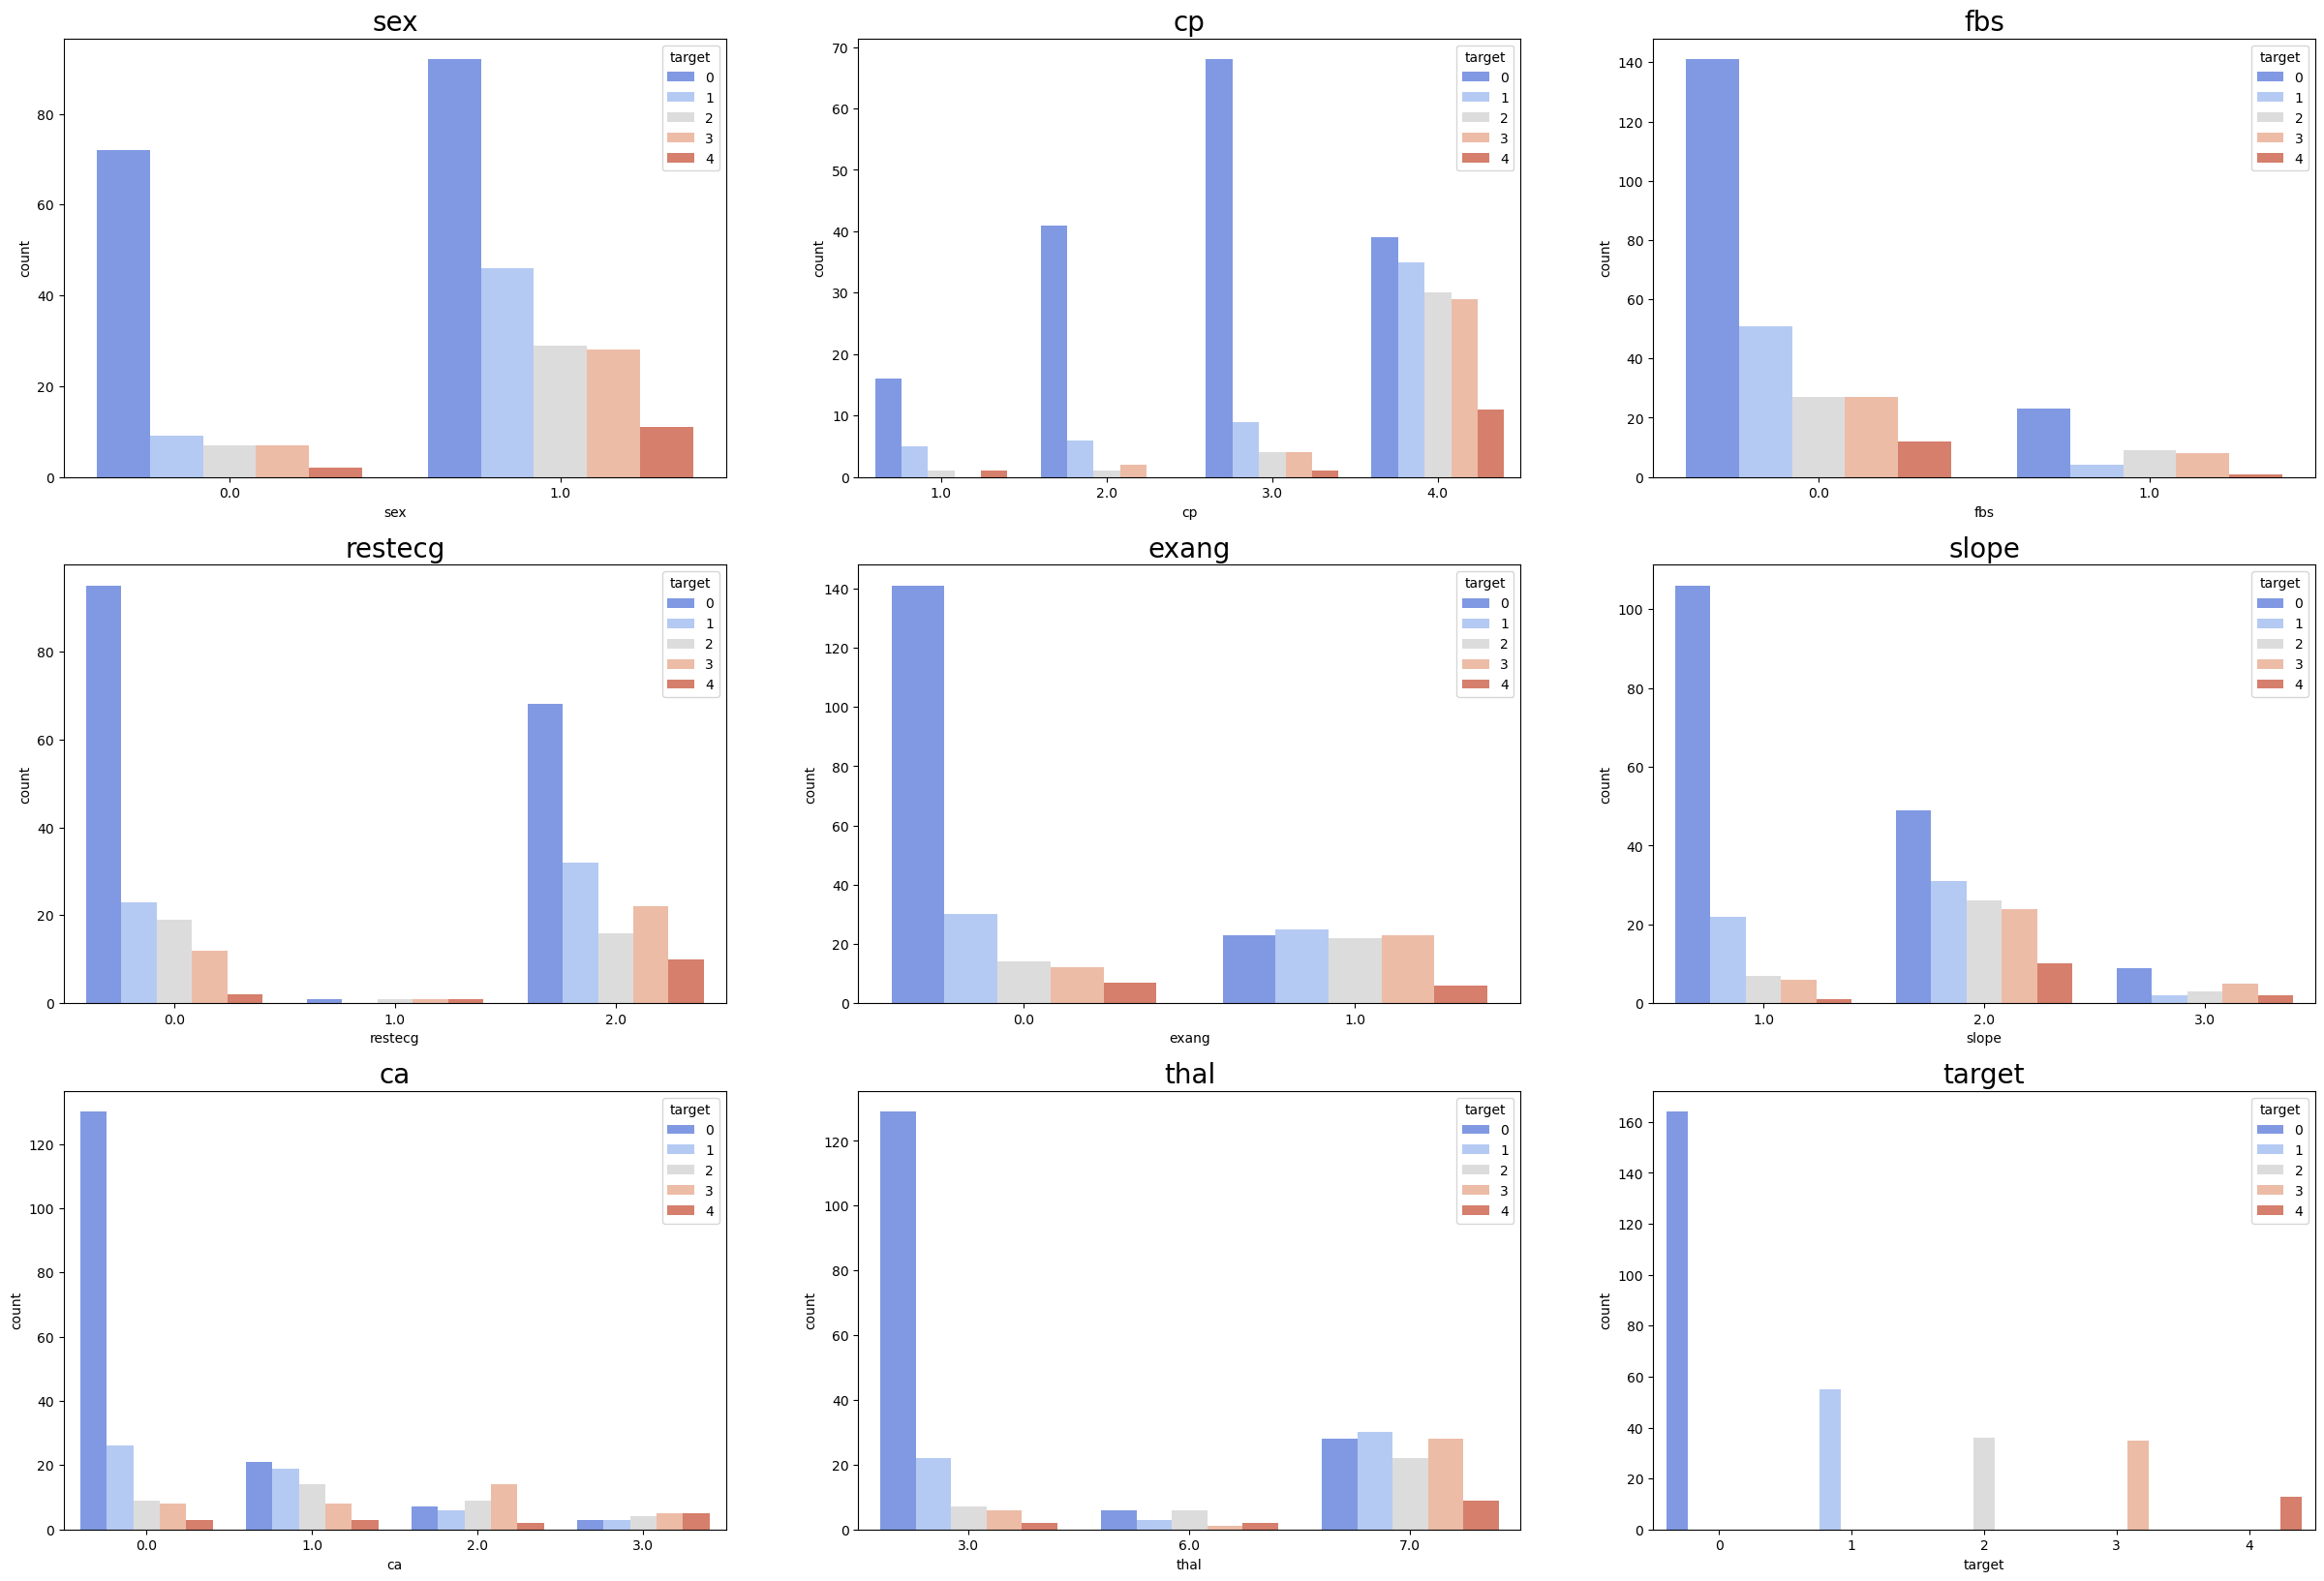

In [21]:
# Countplot for categorical columns
fig, ax = plt.subplots(3, 3, figsize=(30, 20))
for row in range(3):
    for col in range(3):
        column_name = CATEGORICAL_COLS[row*3 + col]
        sns.countplot(df, x=column_name, ax=ax[row, col], hue='target', palette='coolwarm')
        ax[row, col].set_title(column_name, fontsize=20)

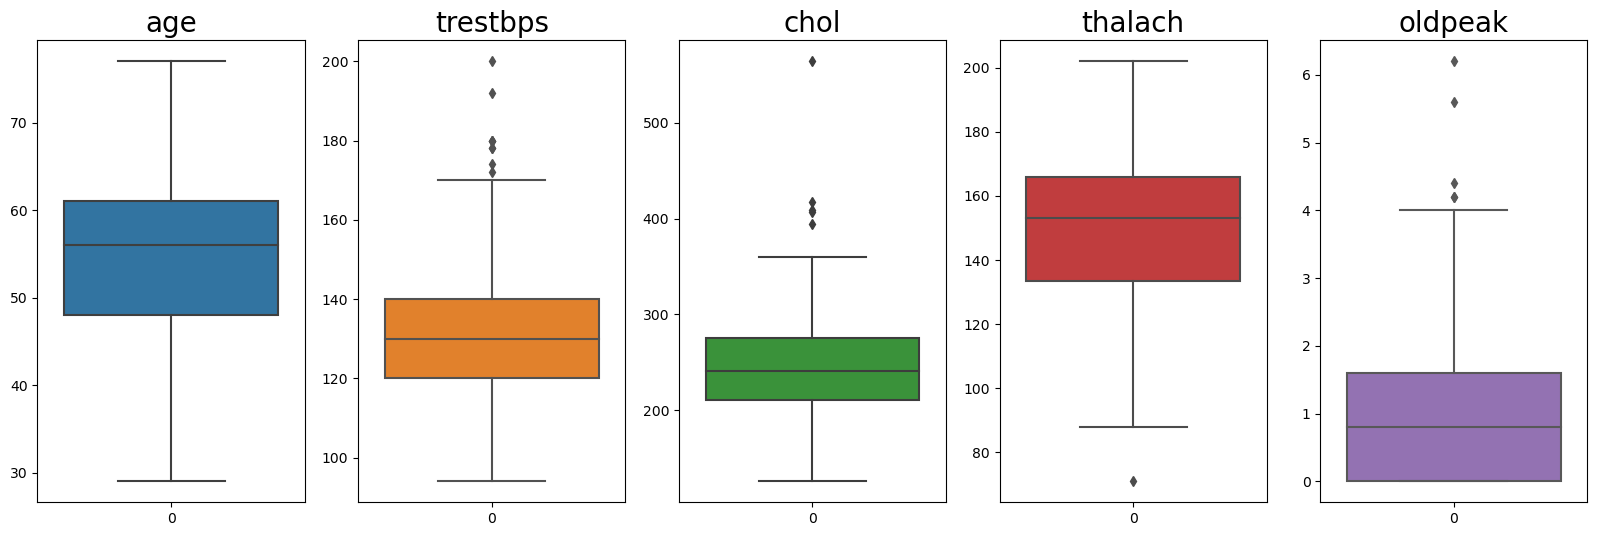

In [22]:
# Boxplots for numeric columns
fig, ax = plt.subplots(1, 5, figsize=(20, 6))
colors = plt.rcParams["axes.prop_cycle"]()
for row in range(1):
    for col in range(5):
        column_name = NUMERIC_COLS[col]
        c = next(colors)["color"]
        sns.boxplot(df[column_name], orient='v', ax=ax[col], color=c)
        ax[col].set_title(column_name, fontsize=20)

# Data wrangling

- **Outliers:** (these are not **all** the outliers but the most **unrealistic** ones)<br/>
    - `chol` above 500
    - `oldpeak` above 5
- **Encoding:**<br/>
    - encode these categorical columns `cp`, `restecg`, `thal` 
    - `slope` and `ca` are ordinal, so we'll keep them as they are


In [23]:
# num of duplicated values
df.duplicated().sum()

0

In [24]:
# missing values
m = df.isnull().sum()
m[m != 0]

ca      4
thal    2
dtype: int64

In [25]:
def clean_data(data):
    df = data.copy()
    
    # impute missing values with the mode
    df.loc[df['ca'].isnull(), 'ca'] = df['ca'].mode()[0]
    df.loc[df['thal'].isnull(), 'thal'] = df['thal'].mode()[0]
    
    # Cap outliers
#     upper_chol = round(df['chol'].quantile(0.995))
#     upper_oldpeak = round(df['oldpeak'].quantile(0.995))
#     print(upper_chol, upper_oldpeak)
#     df['chol'] = np.clip(df['chol'], a_min=None, a_max=upper_chol)
#     df['oldpeak'] = np.clip(df['oldpeak'], a_min=None, a_max=upper_oldpeak)
    
    # encoding categorical data
    cat_cols = ['cp', 'restecg', 'thal'] # not binary or ordinal
    df[cat_cols] = df[cat_cols].astype(int) # to attach to column names as numbers (not float)
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype=int)

        
    # binarize the target
    df.loc[df['target'] > 0, 'target'] = 1
    
    return df

df = clean_data(df)

In [26]:
df.head(2)

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_2,cp_3,cp_4,restecg_1,restecg_2,thal_6,thal_7
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,3.0,0.0,0,0,0,0,0,1,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,2.0,3.0,1,0,0,1,0,1,0,0


## Export the cleaned dataset

In [27]:
# export to CSV
df.to_csv('../data/heart_disease.csv', index=False)

In [30]:
CATEGORICAL_COLS = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target',\
                   'cp_2', 'cp_3', 'cp_4', 'restecg_1', 'restecg_2',\
                    'thal_6', 'thal_7']
NUMERIC_COLS = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']